# Registration playground
‹ Registration_playground.ipynb › Copyright (C) ‹ 2018 › ‹ Andrew Green - andrew.green-2@manchester.ac.uk › This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

---

14052018    afg   First version

18052018    afg   version uploaded to github, paths changed to reflect JEDI config.

---

This notebook is intended to introduce the basics of image registration using only 2D images. We will start by registering some simple 2D shapes, and finish by registering some photographs to a reference individual.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import SimpleITK as sitk

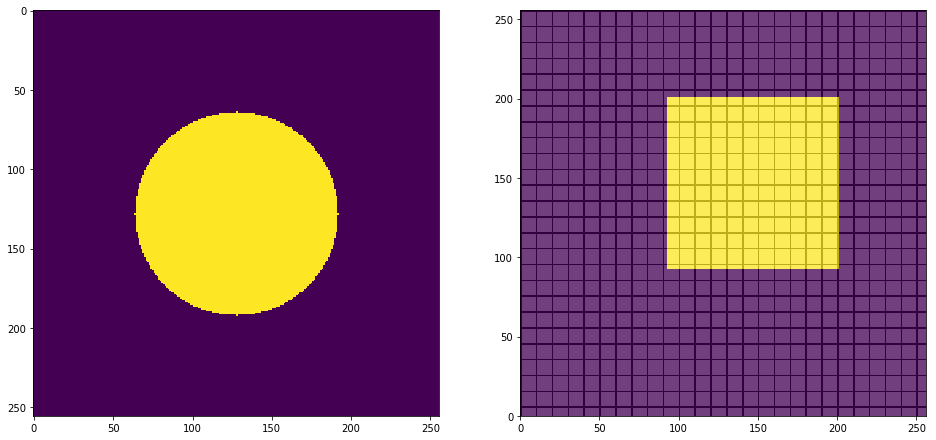

In [4]:
def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask.astype(np.float32)


circle = createCircularMask(256,256, radius = 64)

square = np.zeros((256,256), dtype=np.float32)
square[93:201, 93:201] += 1

## convert to images for sitk
circleImage = sitk.GetImageFromArray(circle)
squareImage = sitk.GetImageFromArray(square)

grid = sitk.GridSource(outputPixelType=sitk.sitkFloat32,
    size=(256, 256),
    sigma=(0.2, 0.2),
    gridSpacing=(10.0, 10.0),
    gridOffset=squareImage.GetOrigin(),#(34.0, 74.0),
    spacing=squareImage.GetSpacing())

grid.SetDirection(squareImage.GetDirection())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,9))

ax1.imshow(circle)

ax2.imshow(square)
ax2.imshow(sitk.GetArrayFromImage(grid), alpha=0.25, extent=[0,256,0,256], cmap="Greys_r")
plt.show()






Final metric value: -0.3797073668718498
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


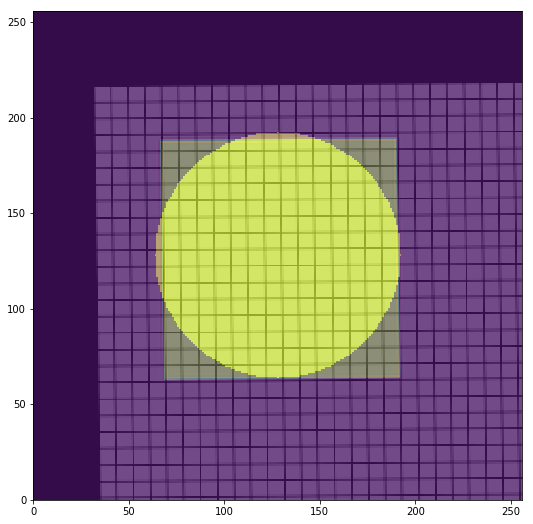

In [5]:

## Do affine registration

def affineRegistration(fixedImage, movingImage, initialTransform):
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    # registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=64)
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=64)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.75)
    # registration_method.SetMetricFixedMask(referenceMask)
    # registration_method.SetMetricMovingMask(floatingMask)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.5, numberOfIterations=100, 
                                                      convergenceMinimumValue=1e-6, convergenceWindowSize=10)

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
#     registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initialTransform, inPlace=False)

    final_transform = registration_method.Execute(fixedImage, movingImage)
    
    
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    
    
    finalImage = sitk.Resample(movingImage, fixedImage, final_transform, sitk.sitkBSpline, 0.0, fixedImage.GetPixelID())
    return (finalImage, final_transform)




initialTransform = sitk.CenteredTransformInitializer(circleImage, squareImage, sitk.AffineTransform(2),
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)

affineSquare, affineTrans = affineRegistration(circleImage, squareImage, initialTransform)

affineGrid = sitk.Resample(grid, circleImage, affineTrans.GetInverse(), sitk.sitkLinear, 0.0, grid.GetPixelID())
 
plt.figure(figsize=(16,9))
plt.imshow(sitk.GetArrayFromImage(circleImage))
plt.imshow(sitk.GetArrayFromImage(affineSquare), alpha=0.5)
plt.imshow(sitk.GetArrayFromImage(affineGrid), alpha=0.25, extent=[0,256,0,256], cmap="Greys_r")

plt.show()

Final metric value: -0.3864489630816166
Optimizer's stopping condition, GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 31.


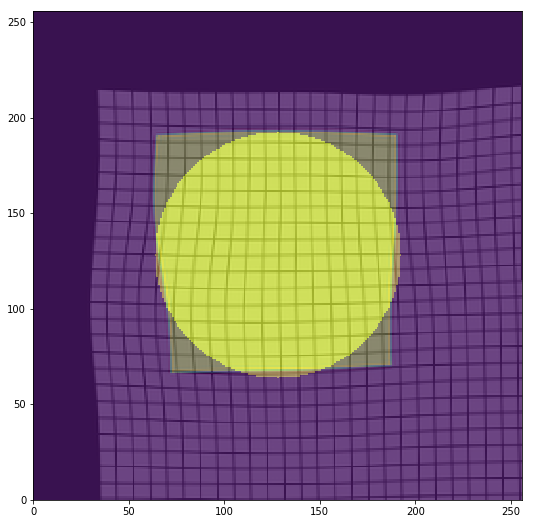

In [6]:
def NonRigidRegistration(fixedImage, movingImage, fixedImageMask=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    grid_physical_spacing = [50.0, 50.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixedImage.GetSize(), fixedImage.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    initial_transform = sitk.BSplineTransformInitializer(image1 = fixedImage, transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)
        
    # registration_method.SetMetricAsMeanSquares()
    # # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be 
    # # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # # whole image.
    # registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    # registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=64)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.05)


    if fixedImageMask:
        registration_method.SetMetricFixedMask(fixedImageMask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
#     registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=2.0, numberOfIterations=100, 
                                                                convergenceMinimumValue=1e-6, convergenceWindowSize=10)

    finalTransform = registration_method.Execute(fixedImage, movingImage)
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    finalImage = sitk.Resample(movingImage, fixedImage, finalTransform, sitk.sitkBSpline, 0.0, fixedImage.GetPixelID())
    return (finalImage, finalTransform)


nrrSquare, dvf = NonRigidRegistration(circleImage, affineSquare)
nrrGrid = sitk.Resample(affineGrid, affineGrid, dvf, sitk.sitkBSpline, 0.0, affineGrid.GetPixelID())

plt.figure(figsize=(16,9))
plt.imshow(sitk.GetArrayFromImage(circleImage))
plt.imshow(sitk.GetArrayFromImage(nrrSquare), alpha=0.5)
plt.imshow(sitk.GetArrayFromImage(nrrGrid), alpha=0.25, extent=[0,256,0,256], cmap="Greys_r")

plt.show()

(592, 452) (592, 452)


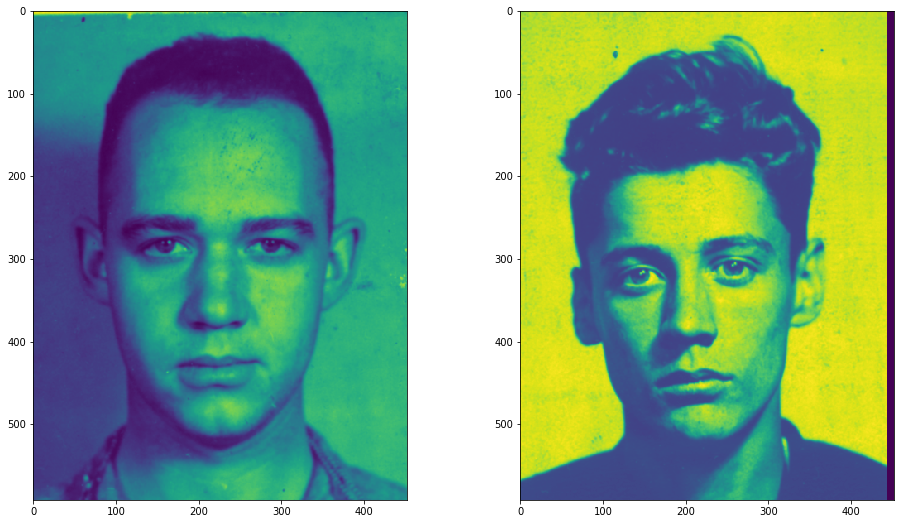

In [7]:
## Now try faces...
referenceFace = sitk.ReadImage("/data/projects/idmrct/faces/01362_1_F.png", sitk.sitkFloat32)

testFace = sitk.ReadImage("/data/projects/idmrct/faces/01459_1_F.png", sitk.sitkFloat32)


## Here we downsample the image by a factor of two in the xy plane. Leave slice direction alone.
    
## These lines get the original metadata from the image (pixel size, origin  etc)
orig_pixelid = referenceFace.GetPixelIDValue()
orig_origin = referenceFace.GetOrigin()
orig_direction = referenceFace.GetDirection()
orig_spacing = np.array(referenceFace.GetSpacing())
orig_size = np.array(referenceFace.GetSize(), dtype=np.int)

## Calculate the new spacing after we downsample
new_spacing = [orig_spacing[0]*2, orig_spacing[1]*2]

## Need to blur first - Nyquist-Shannon theorem
## https://en.wikipedia.org/wiki/Nyquist–Shannon_sampling_theorem
sigma = 2.0/(2.0*np.sqrt(np.pi)) ## blurring sigma depends on downsampling size

## These two lines blur in the x and y planes respectively
referenceFace = sitk.RecursiveGaussian(referenceFace, sigma=sigma*new_spacing[0], direction=0)
referenceFace = sitk.RecursiveGaussian(referenceFace, sigma=sigma*new_spacing[1], direction=1)

testFace = sitk.RecursiveGaussian(testFace, sigma=sigma*new_spacing[0], direction=0)
testFace = sitk.RecursiveGaussian(testFace, sigma=sigma*new_spacing[1], direction=1)  

## Calculate the rest of the new metadata
new_size = orig_size*(orig_spacing/new_spacing)
new_size = np.ceil(new_size).astype(np.int) #  Image dimensions are in integers
new_size = [int(s) for s in new_size] #  SimpleITK expects lists, not ndarrays

## Now run the resampling operation
resample_filter = sitk.ResampleImageFilter()
referenceFace = resample_filter.Execute(referenceFace,
                                               new_size,
                                               sitk.Transform(),
                                               sitk.sitkLinear,
                                               orig_origin,
                                               new_spacing,
                                               orig_direction,
                                               0,
                                               orig_pixelid)

testFace = resample_filter.Execute(testFace,
                                               new_size,
                                               sitk.Transform(),
                                               sitk.sitkLinear,
                                               orig_origin,
                                               new_spacing,
                                               orig_direction,
                                               0,
                                               orig_pixelid)



fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,9))

ax1.imshow(sitk.GetArrayFromImage(referenceFace))

ax2.imshow(sitk.GetArrayFromImage(testFace))
print(sitk.GetArrayFromImage(referenceFace).shape, sitk.GetArrayFromImage(testFace).shape)
plt.show()



Final metric value: -0.3536616641078469
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 31.


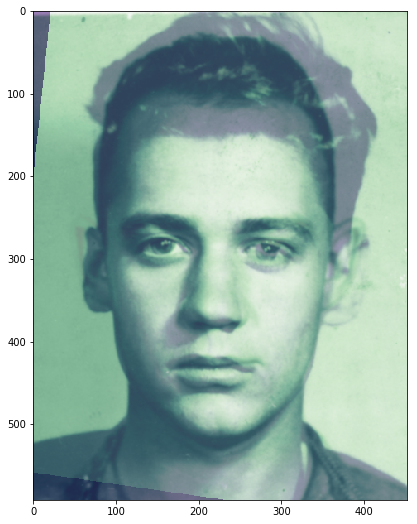

In [8]:
initialTransform = sitk.CenteredTransformInitializer(referenceFace, testFace, sitk.AffineTransform(2),
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)

affineFace, affineTrans = affineRegistration(referenceFace, testFace, initialTransform)

 
plt.figure(figsize=(16,9))
plt.imshow(sitk.GetArrayFromImage(referenceFace), alpha=1.0, cmap="Greens_r")
plt.imshow(sitk.GetArrayFromImage(affineFace), alpha=0.5, cmap="Purples_r")

plt.show()

Final metric value: -0.5620128329365628
Optimizer's stopping condition, GradientDescentLineSearchOptimizerv4Template: Maximum number of iterations (100) exceeded.


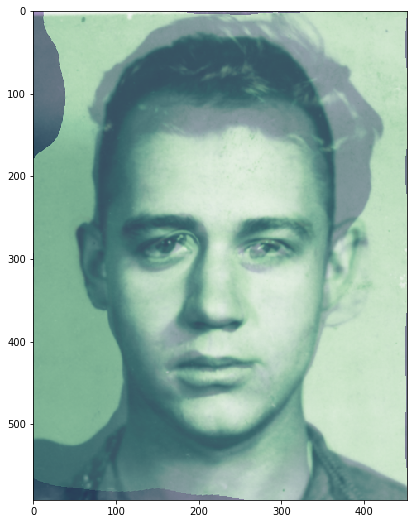

In [9]:
nrrFace, dvf = NonRigidRegistration(referenceFace, affineFace)

plt.figure(figsize=(16,9))
plt.imshow(sitk.GetArrayFromImage(referenceFace), cmap="Greens_r")
plt.imshow(sitk.GetArrayFromImage(nrrFace), alpha=0.5, cmap="Purples_r")

plt.show()